## Import des données et pré-traitement

In [1]:
import pandas as pd
from src.utility.descriptive_statistics import descriptive_statistics

df = pd.read_pickle('src/data/panel_data.pkl')
df["index"] = pd.to_datetime(df["index"])

outlier_dates = [pd.Timestamp('2001-09-11')]
df = df[~df['index'].isin(outlier_dates)]

df = df[(df['index'] >= '1988-01-01') & (df['index'] <= '2017-01-01')]

for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

,index,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5
0,1988-01-04,187.50,193.50,198.25,200.00,202.75
1,1988-01-05,187.50,193.25,197.25,198.25,200.75
2,1988-01-06,191.00,195.75,199.75,201.75,204.50
3,1988-01-07,192.75,198.75,202.75,204.50,208.50
4,1988-01-08,192.50,198.00,202.00,203.50,207.25
...,...,...,...,...,...,...
7288,2016-12-23,345.75,352.50,360.00,367.25,376.25
7289,2016-12-27,355.00,361.25,368.50,375.75,384.25
7290,2016-12-28,348.25,354.75,362.00,369.25,378.25
7291,2016-12-29,349.75,355.75,363.00,370.25,379.25


## Statistiques descriptives

In [2]:
import numpy as np

original_stats, log_stats = descriptive_statistics(df["Maturity 1"])

stats_keys = ['Mean', 'Median', 'Minimum', 'Maximum', 'Std deviation', 'Skewness', 'Kurtosis', 'Autocorrelation', 'ADF test p-value (10 lags)', 'Nb obs']
df_combined_stats = pd.DataFrame(index=stats_keys, columns=['Prices (c/bu)', 'Log returns'])

for key in stats_keys:
    df_combined_stats.loc[key, 'Prices (c/bu)'] = original_stats.get(key, np.nan)
    log_key = 'Log ' + key  
    df_combined_stats.loc[key, 'Log returns'] = log_stats.get(log_key, np.nan)
df_combined_stats

,Prices (c/bu),Log returns
Mean,328.0151,0.0001
Median,269.1875,0.0
Minimum,174.75,-0.272
Maximum,831.25,0.128
Std deviation,143.9133,0.0172
Skewness,1.53,-1.04
Kurtosis,1.57,19.59
Autocorrelation,0.999,0.05
ADF test p-value (10 lags),0.16,0.0
Nb obs,7312,7311


## Graphiques


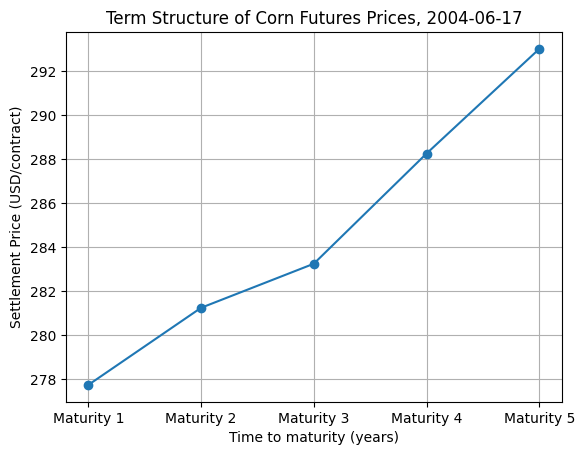

In [3]:
import matplotlib.pyplot as plt
import os 

df.set_index('index', inplace=True)

target_date = '2004-06-17'

prix_17_06_2004 = df.loc[target_date, ['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5']]

plt.plot(['Maturity 1', 'Maturity 2', 'Maturity 3', 'Maturity 4', 'Maturity 5'], prix_17_06_2004 , marker='o', linestyle='-')
plt.xlabel('Time to maturity (years)')
plt.ylabel('Settlement Price (USD/contract)')
plt.title(f'Term Structure of Corn Futures Prices, {target_date}')
plt.grid()

output_dir = 'static/graph'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output_path = os.path.join(output_dir, f'term_structure_{target_date}.png')
plt.savefig(output_path)
plt.show()


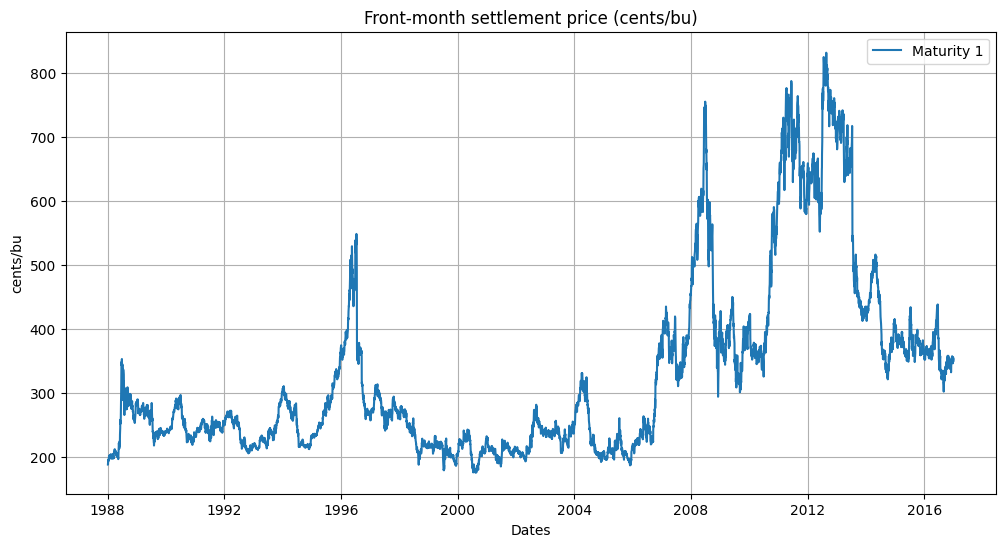

Graph saved to static/graph\price_history.png


In [4]:
from src.graph.graph import plot_and_save_graph

plot_and_save_graph(df, ["Maturity 1"], 
                    "Front-month settlement price (cents/bu)", 
                    "Dates", "cents/bu", 
                    output_filename='price_history.png', 
                    output_dir='static/graph')

# Estimation du modele espace d'etat


## Preparation des données

In [5]:
import pandas as pd
import numpy as np
from src.utility.date import get_t, get_T

df.index = pd.to_datetime(df.index)
df['t'] = df.index.map(get_t)
df[['T1', 'T2', 'T3', 'T4', 'T5']] = pd.DataFrame(df.index.map(lambda x: pd.Series(get_T(x))).tolist(), index=df.index)
for i in range(1, 6):
    df[f'Maturity {i}'] = np.log(df[f'Maturity {i}'])
df
df = df[(df.index >= '1988-02-01') & (df.index <= '2015-01-01')]
df

,Maturity 1,Maturity 2,Maturity 3,Maturity 4,Maturity 5,t,T1,T2,T3,T4,T5
index,,,,,,,,,,,
1988-02-01,5.287004,5.316894,5.331510,5.339939,5.349486,0.084932,0.117808,0.284932,0.452055,0.619178,0.871233
1988-02-02,5.289529,5.316894,5.331510,5.335131,5.345916,0.087671,0.115068,0.282192,0.449315,0.616438,0.868493
1988-02-03,5.292048,5.318120,5.333926,5.338739,5.353042,0.090411,0.112329,0.279452,0.446575,0.613699,0.865753
1988-02-04,5.311974,5.336335,5.350673,5.358942,5.375278,0.093151,0.109589,0.276712,0.443836,0.610959,0.863014
1988-02-05,5.304548,5.332719,5.349486,5.356586,5.367144,0.095890,0.106849,0.273973,0.441096,0.608219,0.860274
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,6.010654,6.031286,6.047372,6.055026,6.069004,0.978082,0.221918,0.389041,0.556164,0.723288,0.975342
2014-12-26,6.027676,6.047372,6.063204,6.069582,6.084499,0.983562,0.216438,0.383562,0.550685,0.717808,0.969863
2014-12-29,6.022842,6.043226,6.059123,6.065528,6.079361,0.991781,0.208219,0.375342,0.542466,0.709589,0.961644


## Estimation du modèle espace d'Etat

In [6]:
from scipy.optimize import minimize
from src.model.kalman import KalmanModel
from src.utility.constant import mu, kappa, sigma1, sigma2, rho, lambdaz
from tqdm import tqdm

def objective(params, observations, times, maturities, n_factors):
    """Objective function for Kalman Model optimization."""
    param_keys = ['mu', 'sigma1', 'lambda1', 'kappa2', 'sigma2', 'lambda2', 'rho12',
                  'kappa3', 'sigma3', 'lambda3', 'rho13', 'rho23',
                  'kappa4', 'sigma4', 'lambda4', 'rho14', 'rho24', 'rho34']
    model_params = {
        key: params[i] for i, key in enumerate(param_keys[:3 + 4 * (n_factors - 1)])
    }
    model_params['maturities'] = maturities
    model_params['current_time'] = times

    model = KalmanModel(n_factors=n_factors, params=model_params)
    return model.compute_likelihood(observations, times, maturities)

observations = df.iloc[:, 0:5].values
times = df["t"].values
maturities = df.iloc[:, 6:11].values

initial_guesses = {
    1: [mu, sigma1, lambdaz],
    2: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho],
    3: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho],
    4: [mu, sigma1, lambdaz, kappa, sigma2, lambdaz, rho, kappa, sigma2, lambdaz, rho, rho, kappa, sigma2, lambdaz, rho, rho, rho]
}

results = {}
for n_factors in tqdm(range(1, 5)):
    result = minimize(
        objective,
        initial_guesses[n_factors],
        args=(observations, times, maturities, n_factors),
        method='BFGS',
        options={'maxiter': 3}    
    )
    results[n_factors] = result
    print(f"Optimized parameters for {n_factors} factors:", result.x)


  0%|          | 0/4 [00:00<?, ?it/s]